dfg                        index       swi                                \
                       index  delta-g1  delta-g2  theta-g1  theta-g2   
13  Active-Hemlata-PrevsPost  0.129809  0.100860  0.886666  0.882582   
14    Active-Malti-PrevsPost  0.298399  0.044857  0.254880  0.040832   
15   Active-Preeti-PrevsPost  0.904868  0.969947  0.878123  0.887569   
16  Active-Sharifa-PrevsPost  0.916941  1.000000  0.086164  0.032510   
17   Active-Vinita-PrevsPost  0.437500  0.117033  0.297387  0.059630   
18      Active-VKS-PrevsPost  0.092593  0.074479  0.437500  0.105174   
19     Active-Nitu-PrevsPost  0.060689  0.020407       NaN       NaN   
20  Active-Ranjeet-PrevsPost  0.482946  0.072658  0.528402  0.368869   
21   Active-Resham-PrevsPost       NaN       NaN  0.471295  0.288429   
22   Active-Rithik-PrevsPost  0.898379  0.613415  0.346965  0.322847   
23    Active-Rohan-PrevsPost  0.373334  0.065833  0.376202  0.032329   
24    Active-Suman-PrevsPost  0.430875  0.276457  0.371397  

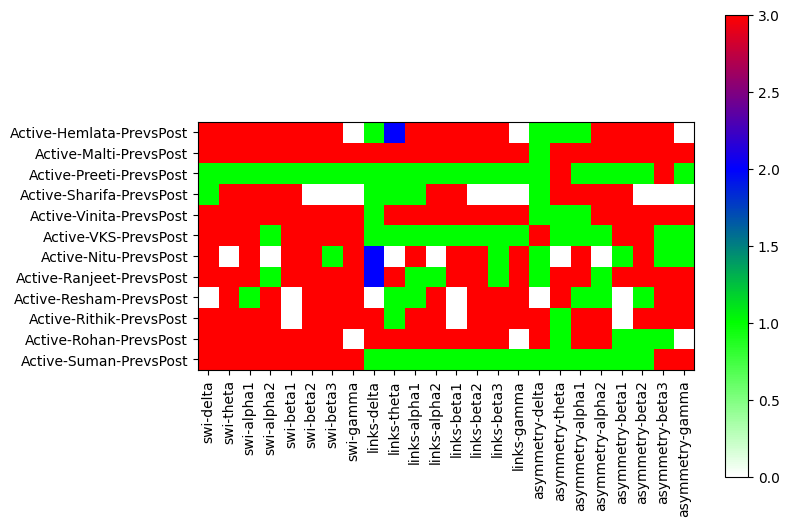

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

ACTIVE_SHAM = 'Active'

existing_file = f"comparison-results/result-{ACTIVE_SHAM}.xlsx"
df = pd.read_excel(existing_file, header=[0,1])
df_without_rows = df.drop(df.index[0:len(df)//2+1])
df_without_columns = df_without_rows.drop(df_without_rows.columns[0:len(df)//2+1], axis=1)
df = df_without_columns
print("df", df)

colors = [(1, 1, 1), (0, 1, 0),  (0, 0, 1), (1, 0, 0)] # white, green, blue, red
values = [0, 1, 2, 3]
cmap = mcolors.LinearSegmentedColormap.from_list("Custom", colors, N=256)

# 0 : If swi values NaN ----- white
# 1 : If post swi > pre swi, post links > pre links, post asymmetry < pre asymmetry ----- green
# 2 : If post swi == pre swi, |post links - pre links| < 3, post asymmetry == pre asymmetry ---- blue
# 3 : If post swi < pre swi, post links < pre links, post asymmetry > pre asymmetry ----- red

condition_matrix = np.zeros((len(df), (len(df.columns) -8) // 2))
for j in range(len(df)): # rows
    insignificant_bands  = []
    for i in range(1, len(df.columns)-8, 2): # cols    
        if i in range(0,16):
            if np.isnan(df.iloc[j, i]):
                condition_matrix[j, i // 2] = 0 # white
                insignificant_bands.append(i)
            # else:
            elif df.iloc[j, i] < df.iloc[j, i + 1]: 
                condition_matrix[j, i // 2] = 1 # green
            elif df.iloc[j, i] == df.iloc[j, i + 1]:
                condition_matrix[j, i // 2] = 2 # blue
            else:
                condition_matrix[j, i // 2] = 3 # red
        elif i in range(16,32):
            if i-16 in insignificant_bands:
                condition_matrix[j, i // 2] = 0 # white
            elif df.iloc[j, i] < df.iloc[j, i + 1]:
                condition_matrix[j, i // 2] = 1 # green 
            elif np.abs(df.iloc[j, i] - df.iloc[j, i + 1]) <= 5: # links difference <= 5
                condition_matrix[j, i // 2] = 2 # blue
            else:
                condition_matrix[j, i // 2] = 3 # red
        elif i in range(32,48):
            if i-32 in insignificant_bands:
                condition_matrix[j, i // 2] = 0 # white
            # else:
            elif np.abs(df.iloc[j, i] - 1) > np.abs(df.iloc[j, i+1] - 1): 
                condition_matrix[j, i//2] = 1 # green
            elif np.abs(df.iloc[j, i] - 1) == np.abs(df.iloc[j, i+1] - 1): 
                condition_matrix[j, i//2] = 2 # blue
            else:
                condition_matrix[j, i//2] = 3 # red

lis = [f"{df.columns[i][0]}-{df.columns[i][1].split('-')[0]}" for i in range(1, len(df.columns)-8, 2)]

plt.figure(figsize=(8, 6))
plt.imshow(condition_matrix, cmap=cmap)
plt.xticks(range(((len(df.columns)-8)// 2)), lis, rotation='vertical')
plt.yticks(range(len(df)), list(df.iloc[:, 0]))
plt.colorbar()
plt.show()

In [10]:
# import pandas as pd
# import statsmodels.api as sm
# import statsmodels.formula.api as smf

# # Create a DataFrame with your data
# data = {
#     'group': ['active']*10 + ['placebo']*6,
#     'small_worldedness': [1.2, 1.3, 1.4, 1.1, 1.5, 1.6, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3, 1.4, 1.1, 1.2, 1.3],
#     'num_links': [100, 110, 95, 105, 115, 90, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110, 95, 105, 100, 110],
#     'asymmetry': [0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2, 0.3, 0.1, 0.2],
#     'brain_region': ['A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B', 'C', 'A', 'B']
# }
# df = pd.DataFrame(data)

# # Fit a linear regression model
# model = smf.ols(formula='small_worldedness ~ group + num_links + asymmetry + brain_region', data=df)
# results = model.fit()

# # Print the regression results
# print(results.summary())
